# Please upvote if you like this kernel


# Recommendation System Project


# Import Libraries 

In [3]:

#importing necessary Libraries 

#working with data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection


import sklearn 
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier

from collections import defaultdict
from surprise import SVD
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split
import os


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/amazon-product-reviews/ratings_Electronics (1).csv


### <font color='red'>Step 1 </font> Read and explore the given dataset

In [4]:
Data=pd.read_csv("/kaggle/input/amazon-product-reviews/ratings_Electronics (1).csv",names=['UserId', 'ProductId','Rating','timestamp'])


In [5]:
# Display the data

Data.head()


,UserId,ProductId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [6]:
#checking datatypes of each column
Data.dtypes

UserId        object
ProductId     object
Rating       float64
timestamp      int64
dtype: object

In [7]:
#shape of data 
shape_Data = Data.shape
print('Data set contains "{x}" number of rows and "{y}" number of columns' .format(x=shape_Data[0],y=shape_Data[1]))

Data set contains "7824482" number of rows and "4" number of columns


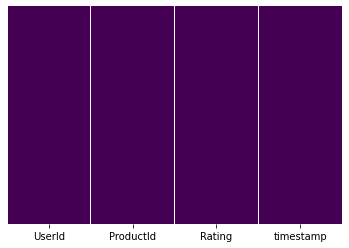

In [8]:
#null check
sns.heatmap(Data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [9]:
#Oveview of Data
Data.describe().T

,count,mean,std,min,25%,50%,75%,max
Rating,7824482.0,4.012337e+00,1.380910e+00,1.0,3.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
timestamp,7824482.0,1.338178e+09,6.900426e+07,912729600.0,1.315354e+09,1.361059e+09,1.386115e+09,1.406074e+09


In [10]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",Data.shape[0])
print("Total No of Users   :", len(np.unique(Data['UserId'])))
print("Total No of products  :", len(np.unique(Data['ProductId'])))


Total data 
--------------------------------------------------

Total no of ratings : 7824482
Total No of Users   : 4201696
Total No of products  : 476002


#### Data Understanding
1. There is no MISSING data <br>
2. There are 4 Attributes - *UserId*, *ProductId* are object *Rating* is Integer while *Timestamp* is float <br>
3. Rating lies between 1-5

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Rating')]

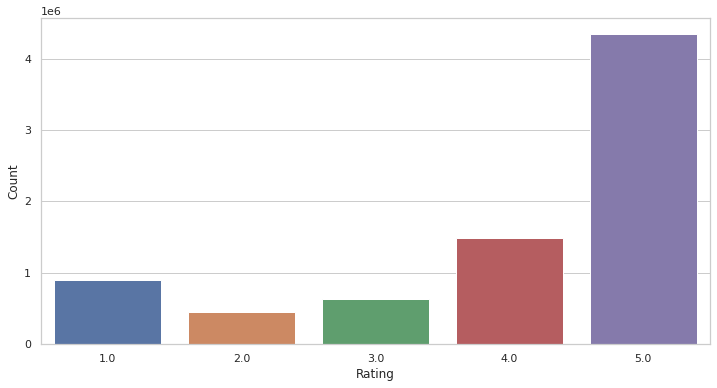

In [11]:
# Rating frequency

sns.set(rc={'figure.figsize': (12, 6)})
sns.set_style('whitegrid')
ax = sns.countplot(x='Rating', data=Data)
ax.set(xlabel='Rating', ylabel='Count')

* most User Rated 5

In [12]:
# let's check what is on avarage rating of each product
Rating_prod = Data.groupby('ProductId')['Rating'].mean()
Rating_prod.head()

ProductId
0132793040    5.000000
0321732944    5.000000
0439886341    1.666667
0511189877    4.500000
0528881469    2.851852
Name: Rating, dtype: float64

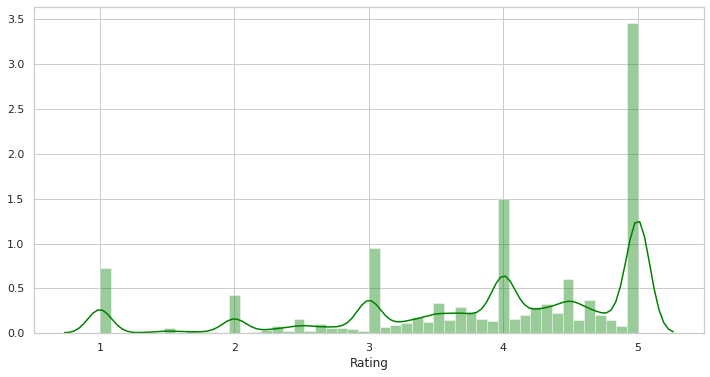

In [13]:
sns.distplot(Rating_prod, color="green", kde=True)

#### We can notice that large peak of rating "5", this may be because single user rating or some other kind of skewness.

In [14]:
# let's check how many rating does a product have

product_rating_count = Data.groupby('ProductId')['Rating'].count()
product_rating_count.head()

ProductId
0132793040     1
0321732944     1
0439886341     3
0511189877     6
0528881469    27
Name: Rating, dtype: int64

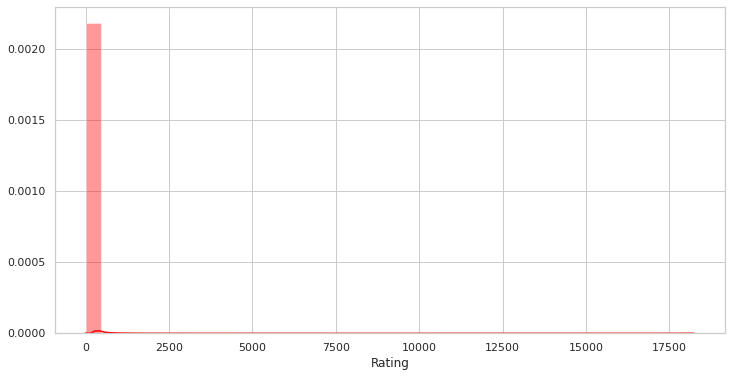

In [15]:
sns.distplot(product_rating_count, color="red", kde=True, bins=40)

#### this shows that most items have around 0-100 rating, with some outliers such as product having more then 2000 rating

In [16]:
#Analysis of rating given by the user 

no_of_rated_products_per_user = Data.groupby(by='UserId')['Rating'].count().sort_values(ascending=False)
no_of_rated_products_per_user.head()

UserId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
Name: Rating, dtype: int64

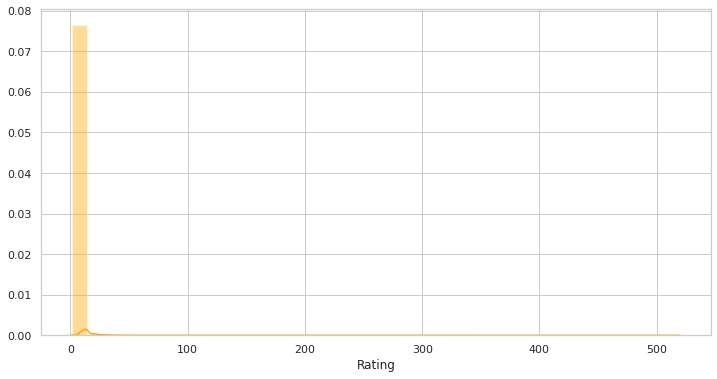

In [17]:
sns.distplot(no_of_rated_products_per_user, color="Orange", kde=True, bins=40)

#### this shows that most user have rated just 1 item, with some outliers such as user rating more then 100 item.

### <font color='red'>Step 2 </font> Take a subset of the dataset to make it less sparse/ denser.

In [18]:
# checking number of users how gave 1 rating rating only.
user_1=no_of_rated_products_per_user[no_of_rated_products_per_user==1].count()
#percentage of user who gave rating only one time are
per = user_1/no_of_rated_products_per_user.count()
print('Total {} percent of User have just given rating once'.format(per*100))

Total 68.58735139334212 percent of User have just given rating once


In [19]:
print('\n Number of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )


 Number of rated product more than 50 per user : 1540



In [20]:
#Getting the new dataframe which contains users who has given 50 or more ratings

new_Data=Data.groupby("ProductId").filter(lambda x:x['Rating'].count() >=50)

In [21]:
new_Data.head()

,UserId,ProductId,Rating,timestamp
183,A1BKC6B7YHYTVV,0972683275,4.0,1405382400
184,AWVFSIB42LHKJ,0972683275,4.0,1405209600
185,A36MQBNADRH8YY,0972683275,5.0,1405641600
186,A3SRXMPLAEZ6DP,0972683275,4.0,1405987200
187,A20XXTXWF2TCPY,0972683275,5.0,1405123200


In [22]:
new_Data.shape

(5374313, 4)

In [23]:
#percentage of data taken
print('we are taking {} percent of data from Raw data for analysis'.format(new_Data['UserId'].count()/Data['UserId'].count()*100))

we are taking 68.68586316640514 percent of data from Raw data for analysis


In [24]:
#Dropping Unwanted Columns
new_Data.drop('timestamp',inplace=True,axis=1)

### <font color='red'>Step 3 </font> Build Popularity Recommender model.

In [25]:
#group by product and corresponding mean rating
ratings_mean_count = pd.DataFrame(new_Data.groupby('ProductId')['Rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(new_Data.groupby('ProductId')['Rating'].count())

In [26]:
#let's check for highest rating count
ratings_mean_count['rating_counts'].max()

18244

In [27]:
#let's check for highest rating count
ratings_mean_count['rating_counts'].min()

50

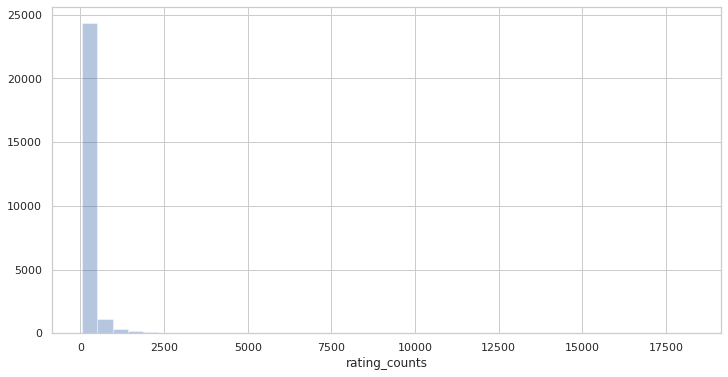

In [28]:
#checking distribution of rating_counts
sns.distplot(ratings_mean_count['rating_counts'],kde=False, bins=40)

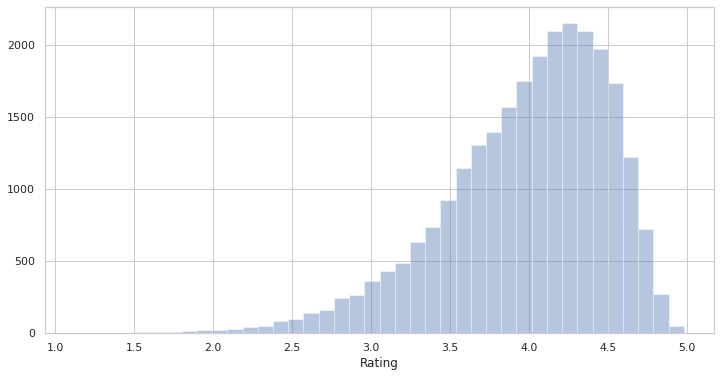

In [29]:
#checking distribution of rating
sns.distplot(ratings_mean_count['Rating'],kde=False, bins=40)

In [30]:
#Top 10 Product that would be recommended.
popular=ratings_mean_count.sort_values(['rating_counts','Rating'], ascending=False)
popular.head(10)

,Rating,rating_counts
ProductId,,
B0074BW614,4.491504,18244
B00DR0PDNE,3.931020,16454
B007WTAJTO,4.424005,14172
B0019EHU8G,4.754497,12285
B006GWO5WK,4.314657,12226
B003ELYQGG,4.392528,11617
B003ES5ZUU,4.704749,10276
B007R5YDYA,4.690926,9907
B00622AG6S,4.420136,9823


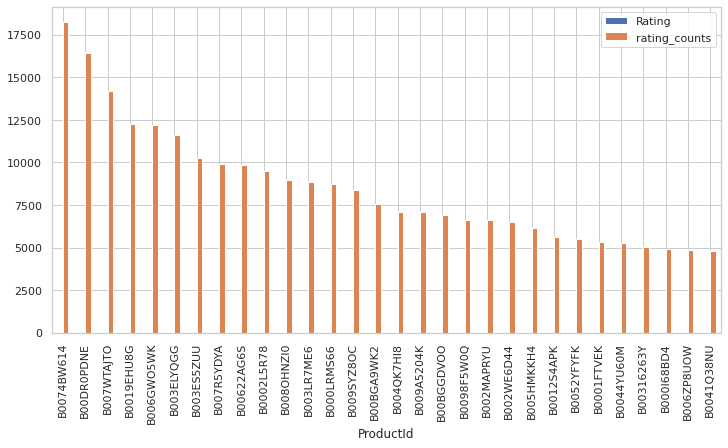

In [31]:
#Top 30 Product that would be recommended.
popular.head(30).plot(kind='bar')

#### The above graph gives us the most popular products (arranged in descending order) sold by the business.

### <font color='red'>Step 4 </font>Split the data randomly into train and test dataset.

In [32]:
#Reading the dataset using Surprise package for Model Based Collaborative Filtering
reader = Reader(rating_scale=(1, 5))
data_reader_SVD = Dataset.load_from_df(new_Data,reader)
#Splitting the dataset with 70% training and 30% testing using Surprise train_test_split
trainset_SVD, testset_SVD = train_test_split(data_reader_SVD, test_size=.30)

In [33]:
#Data Split for Memory Based Collaborative Filtering
# we were going out of memory problem so lets take first 10lac record to Collaborative filtering process.
# so splitting data in diffrent part to train them saparately 
# splitting data into 5 Equal parts of 1074862 record each
reader = Reader(rating_scale=(1, 5))
data_reader_1 = Dataset.load_from_df(new_Data.iloc[:1074862,0:],reader)
data_reader_2 = Dataset.load_from_df(new_Data.iloc[1074862:2149725,0:],reader)
data_reader_3 = Dataset.load_from_df(new_Data.iloc[2149725:3224586,0:],reader)
data_reader_4 = Dataset.load_from_df(new_Data.iloc[3224586:4299448,0:],reader)
data_reader_5 = Dataset.load_from_df(new_Data.iloc[4299448:,0:],reader)

#Splitting the dataset with 70% training and 30% testing using Surprise train_test_split
trainset_1, testset_1 = train_test_split(data_reader_1, test_size=.30)
trainset_2, testset_2 = train_test_split(data_reader_2, test_size=.30)
trainset_3, testset_3 = train_test_split(data_reader_3, test_size=.30)
trainset_4, testset_4 = train_test_split(data_reader_4, test_size=.30)
trainset_5, testset_5 = train_test_split(data_reader_5, test_size=.30)

#holding all training set
trainset=[trainset_1,trainset_2,trainset_3,trainset_4,trainset_5]
#holding all testing set
testset=[testset_1,testset_2,testset_3,testset_4,testset_5]

### <font color='red'>Step 5 </font>Build Collaborative Filtering model 
#### Memory Based Collaborative Filtering

* Collaborative filtering techniques aim to fill in the missing entries of a user-item association matrix.
* We are going to use collaborative filtering approach. This is based on the idea that the best recommendations come from people who have similar tastes.

In [34]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})

In [35]:
#fitting all training set and storing testing results
test=[]
for item in range(5):
    algo.fit(trainset[item])
    test.append(algo.test(testset[item]))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [36]:
#checking prediction
test[0][0:5]

[Prediction(uid='A3S0TY3548XQ1N', iid='B000RGG5GU', r_ui=4.0, est=3.0980392156862746, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A15N48O6R2YXDP', iid='B00001P4XH', r_ui=5.0, est=4.0559128552119015, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A2OC5SGVVHTBDX', iid='B000VX6XL6', r_ui=5.0, est=4.0559128552119015, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A1FT9JS91P4C8U', iid='B0007U0GZM', r_ui=5.0, est=4.152777777777778, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='ABB6L6KGBUC7V', iid='B000P0PF8C', r_ui=5.0, est=4.0559128552119015, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})]

#### Model-based collaborative filtering system

In [37]:
algo_SVD = SVD()
algo_SVD.fit(trainset_SVD)

In [38]:
predictions_SVD = algo.test(testset_SVD)

In [39]:
RMSE_SVD=accuracy.rmse(predictions_SVD, verbose=True)

RMSE: 1.2575


### <font color='red'>Step 6 </font>Evaluate both the models.

#### Evaluating Popularity based model

In [40]:
popular=ratings_mean_count.sort_values(['rating_counts','Rating'], ascending=False)
popular.head(10)

,Rating,rating_counts
ProductId,,
B0074BW614,4.491504,18244
B00DR0PDNE,3.931020,16454
B007WTAJTO,4.424005,14172
B0019EHU8G,4.754497,12285
B006GWO5WK,4.314657,12226
B003ELYQGG,4.392528,11617
B003ES5ZUU,4.704749,10276
B007R5YDYA,4.690926,9907
B00622AG6S,4.420136,9823


#### We can see top product i.e. B0074BW614 have rating 4.49 and number of user who gave rating to this product is 18244, which seems legit thus we can conclude we are getting expected result

#### evaluating Collobarative filtering (memory based model)

In [41]:
# evaluating Collobarative filtering (memory based model)
print("Item-based Model : Test Set")
RMSE = []
Total_RMSE = 0
for i in range(5):
    RMSE.append(accuracy.rmse(test[i], verbose=True))
    Total_RMSE = Total_RMSE + RMSE[i]

Item-based Model : Test Set
RMSE: 1.3349
RMSE: 1.3804
RMSE: 1.3601
RMSE: 1.3063
RMSE: 1.3184


In [42]:
#avarage RMSE
print ('Avarage RMSE for Memory Based Collaborative Filtering of all TEST data is = {}'.format(Total_RMSE/5))

Avarage RMSE for Memory Based Collaborative Filtering of all TEST data is = 1.3400072301436208


#### Evaluating Collobarative filtering (Model based model)

In [43]:
# evaluating Collobarative filtering (Model based model)
print ('Avarage RMSE for Model Based Collaborative Filtering of all TEST data is = {}'.format(RMSE_SVD))


Avarage RMSE for Model Based Collaborative Filtering of all TEST data is = 1.257503480536004


### <font color='red'>Step 6 </font> Get top - K ( K = 5) recommendations.

In [44]:
#creating function to get top 5 Product Recommendation for each user.
def get_top_n(predictions, n=5):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [45]:
top_n = get_top_n(predictions_SVD, n=5)

In [46]:
# Print the recommended items for first 50 user
count=0
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])
    if(count>49):
        break
    count=count+1

A1DA3C4V9Y6TWX ['B007Q45EF4', 'B0002CZHN6', 'B005DKZTMG']
A2FWY20HZ7RY3O ['B0073WAK8K']
A20NRZH8TMYL4F ['B00BQ5KHJW']
A3JRJWFRJ5KL2L ['B000IF4788']
A1MENM4Y354FC6 ['B000H96IN2']
A305JULLYTE0BQ ['B00B5J73J6']
AUF6YC6JPDZJZ ['B00E4JEDWE']
A13ZLDJRXK6R9U ['B000H859RE', 'B0011ZCDKS']
A13MPUCB4P26UM ['B005YXXT7Y']
A3JMHBT1YT2G6W ['B004P8FATE']
AMS41Q2N4UA30 ['B005DOK8NW', 'B005PXMKI2']
A1I002WK1LELAO ['B001EYV690', 'B004EYSMGW', 'B0029F21LA', 'B007WTAJTO']
A3VXN9CNH3YWHK ['B006UMMPGE']
A2G84LH2M53W5S ['B004S4R5CK', 'B007ADFKAK']
A336NN57HXAVYV ['B00JRULWM4', 'B002BW0MNU', 'B007QUBYDY', 'B0088IA9PC', 'B0072XQILS']
A1LK8RLNN0SM6U ['B002T1OJZU']
AQUQ2COYD2SCD ['B001PTH0VW', 'B009WSCW4S']
A2TZ522I20976Z ['B004SD1XB0']
AQT9BS27RWRWZ ['B0047DVRQW']
ADE6RHHG0SWWM ['B001B077PO', 'B004S4R5CK', 'B00006HVT4', 'B000KZW9WM', 'B0000510ZO']
A1087JNYKPB1NR ['B00B9996LA']
AAZSMHH6LZIU0 ['B000UOMGU8']
A3IWHS6BZL9RLA ['B0002IOIMQ', 'B003M5GVJY']
A2QQ5043U6WPZ2 ['B0030MITDK', 'B000BP8AY2', 'B002T1OJZU', 'B0089

#### Thus we can notice
* For User :A359EJJXW154UD  
* Recommendation : ['B000M2TAN4', 'B000FGI970', 'B0041OSQ9I', 'B00005LEN4', 'B000ZMCILW']

* There are many Users which having less then 5 Reccomendation that occurs because those products have missing ratings via users.
* so people having less then 5 recommendations, we will feed in product based on Popularity Based Recommendation.